In [1]:
import pandas as pd
import numpy as np
from math import ceil

# plotting
import matplotlib.pyplot as plt
#import seaborn as sns

# handling trajectory and other geo-data
import geopandas as gpd
import movingpandas as mpd
from shapely.geometry import Point, LineString, Polygon
from shapely import wkt
from shapely.wkt import loads

#2 min

# points = pd.read_pickle("Data/points.pkl")
# # display(points_df.head())
# trajs_df = pd.read_pickle("Data/trajectories.pkl")
# # display(trajs_df.head())

points_file = '../Data/gbg_trajectories_points_2019.csv'
trajs_file = '../Data/gbg_trajectories_2019_crossing.csv'
points_pickle_file = '../Data/points.pkl'
trajs_pickle_file = '../Data/trajectories.pkl'

points = pd.read_pickle(points_pickle_file)
display(points.head())
trajs_df = pd.read_pickle(trajs_pickle_file)
display(trajs_df.head())

,,x,y,timestamp,trajectory_sid
,trajectory_sid,,,,
931193,1,322906.188012,6.416545e+06,2019-09-04 15:58:49+02:00,1
931194,1,322874.393157,6.416413e+06,2019-09-04 15:58:54+02:00,1
931195,1,322844.134677,6.416278e+06,2019-09-04 15:58:59+02:00,1
931196,1,322816.213664,6.416140e+06,2019-09-04 15:59:04+02:00,1
931197,1,322794.293079,6.415999e+06,2019-09-04 15:59:09+02:00,1


In [2]:
# points = points[len(points)-500000:]
points['segment_distance'] = np.nan
points['segment_duration'] = np.nan
points.tail()

,x,y,timestamp,trajectory_sid,segment_distance,segment_duration
13438326,321774.871021,6.409367e+06,2019-12-18 09:29:55+01:00,1790082,NaN,NaN
13438327,322598.491702,6.391262e+06,2019-12-31 22:34:06+01:00,1790699,NaN,NaN
13438328,307774.450960,6.393742e+06,2019-12-31 23:46:08+01:00,1791234,NaN,NaN
13438329,327900.608974,6.402742e+06,2019-12-23 19:32:18+01:00,1791850,NaN,NaN
13438330,319235.183246,6.406120e+06,2019-12-18 11:33:32+01:00,1793519,NaN,NaN


In [3]:
# 10 min

def compute_distance(row):
    if row.name == 0 or row['trajectory_sid'] != row['prev_trajectory_sid']:
        return 0
    t1 = (row['prev_x'], row['prev_y'])
    t2 = (row['x'], row['y'])
    return Point(t1).distance(Point(t2))

# Before using, you need to create previous value columns
points['prev_x'] = points['x'].shift(1)
points['prev_y'] = points['y'].shift(1)
points['prev_trajectory_sid'] = points['trajectory_sid'].shift(1)

points['segment_distance'] = points.apply(compute_distance, axis=1)

# Cleanup
points.drop(columns=['prev_x', 'prev_y', 'prev_trajectory_sid'], inplace=True)


# 2min

def compute_time_diff(row):
    if row.name == 0 or row['trajectory_sid'] != row['prev_trajectory_sid']:
        return np.nan
    time_diff = row['timestamp'] - row['prev_timestamp']
    return time_diff.total_seconds()

# Before using, you need to create previous value columns
points['prev_timestamp'] = points['timestamp'].shift(1)
points['prev_trajectory_sid'] = points['trajectory_sid'].shift(1)

points['segment_duration'] = points.apply(compute_time_diff, axis=1)

# Cleanup
points.drop(columns=['prev_timestamp', 'prev_trajectory_sid'], inplace=True)



In [4]:
points['segment_velocity (m/s)'] = 0

points['segment_velocity (m/s)'] = np.where(
    points['segment_duration'] != 0,
    points['segment_distance'] / points['segment_duration'],
    0
)

points['segment_velocity (km/h)'] = points['segment_velocity (m/s)'] * 3.6



In [5]:
vel_means = pd.DataFrame()
grouped_20_rows = points.groupby('trajectory_sid')
vel_means['mean_velocity'] = grouped_20_rows['segment_velocity (km/h)'].mean()
vel_means['Number of data points'] = grouped_20_rows['trajectory_sid'].count()
vel_means['duration'] = grouped_20_rows['segment_duration'].sum()
vel_means = vel_means.drop(vel_means[vel_means['duration'] == 0].index)
vel_means['total_distance'] = grouped_20_rows['segment_distance'].sum()
vel_means['duration/frequency'] = vel_means['duration'] / vel_means['Number of data points']
vel_means['frequency/duration'] = vel_means['Number of data points'] / vel_means['duration']
vel_means = vel_means.dropna()
vel_means.head()

,mean_velocity,Number of data points,duration,total_distance,duration/frequency,frequency/duration
trajectory_sid,,,,,,
1,95.627061,56,275.0,7304.844915,4.910714,0.203636
3,95.396003,35,170.0,4504.811231,4.857143,0.205882
4,82.651597,139,710.0,16329.491799,5.107914,0.195775
7,87.946525,83,420.0,10044.958281,5.060241,0.197619
11,88.442302,126,708.0,17367.557538,5.619048,0.177966


In [6]:
#vel_means['frequency/duration'].max()
vel_means[vel_means['frequency/duration'] == vel_means['frequency/duration'].max()].iloc[0]

mean_velocity              -35.178007
Number of data points      315.000000
duration                     5.000000
total_distance           80233.631827
duration/frequency           0.015873
frequency/duration          63.000000
Name: 8441635, dtype: float64

In [7]:
over_120 = vel_means[vel_means['mean_velocity'] > 120]
under_120 = vel_means[vel_means['mean_velocity'] <= 120]
max_duration_frequency = over_120['duration/frequency'].max()
result = over_120[over_120['duration/frequency'] == max_duration_frequency]

print(over_120['duration/frequency'].mean())
print(over_120['duration/frequency'].std())
print(under_120['duration/frequency'].mean())
print(under_120['duration/frequency'].std())
print(over_120['frequency/duration'].mean())
print(over_120['frequency/duration'].std())
print(under_120['frequency/duration'].mean())
print(under_120['frequency/duration'].std())

15.886241729114571
59.03507867855515
92.65359296671826
247.6204202386109
0.23899906563104056
0.2535943852675301
0.1850303962390755
0.37080947955600113


### Stats

In [28]:
over_120 = vel_means[vel_means['mean_velocity'] > 120]
under_120 = vel_means[vel_means['mean_velocity'] <= 120]
under_120 = under_120[under_120['mean_velocity'] > 10]

your_data_1 = under_120[(under_120['frequency/duration'] < 2) & (under_120['Number of data points'] > 2)]['frequency/duration']
your_data_2 = over_120[(over_120['frequency/duration'] < 2) & (over_120['Number of data points'] > 2)]['frequency/duration']

In [39]:
# your_data_1 = your_data_1.sort_values()
your_data_1 = your_data_1.loc[your_data_1 >0]
# yd2_sorted = your_data_2.sort_values()
your_data_2 = your_data_2.loc[your_data_2 >0]


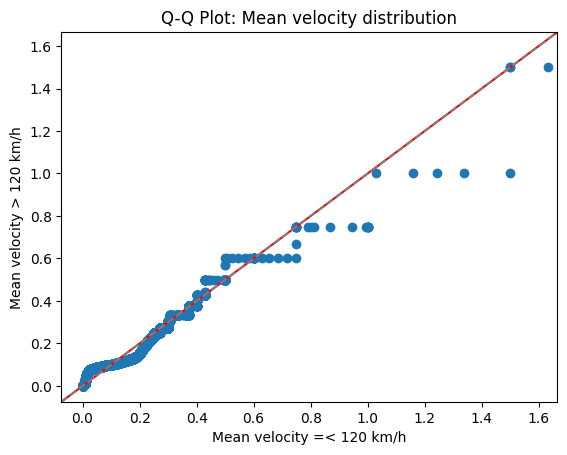

In [40]:
import statsmodels.api as sm

sm.qqplot_2samples(your_data_1, your_data_2, line='45', xlabel='Mean velocity =< 120 km/h', ylabel='Mean velocity > 120 km/h')

# Add a diagonal line for reference (line of equality)
plt.plot([-3, 3], [-3, 3], color='gray', linestyle='--')

# Customize the plot
plt.title("Q-Q Plot: Mean velocity distribution")
plt.show()

In [42]:
print('Number of data points for mean velocity < 120 km/h: ', len(your_data_1))
print('Number of data points for mean velocity >= 120 km/h: ', len(your_data_2))

Number of data points for mean velocity < 120 km/h:  466284
Number of data points for mean velocity >= 120 km/h:  51831


Mean velocity < 120 km/h mean, var, and std:  0.11934304400011808 4848.173744654395 69.62882840213811
Mean velocity >= 120 km/h mean, var, and std:  0.11653573884777922 339.12919049492757 18.41546063759817
T-statistic: 6.059517297882641
P-value: 1.366242743791721e-09
Reject the null hypothesis: There is a significant difference between the two groups.


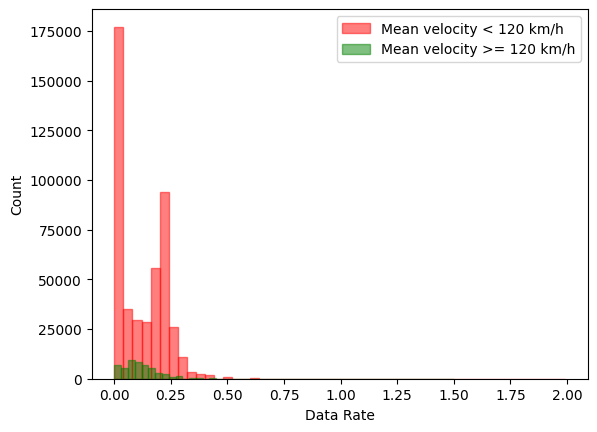

In [50]:
# Two-sample ttest
# Histogram
from scipy import stats

np.random.seed(42)

#Creating sample
random_sample = np.random.choice(your_data_1, len(your_data_2), replace=False)

# Calculate the rank sums
n1 = len(your_data_1)
n2 = len(your_data_2)

t_stat, p_value = stats.ttest_ind(your_data_1, your_data_2)

# Output the results
print('Mean velocity < 120 km/h mean, var, and std: ', np.mean(your_data_1), np.var(your_data_1, ddof=(n1-1)), np.std(your_data_1, ddof=(n1-1)))
print('Mean velocity >= 120 km/h mean, var, and std: ', np.mean(your_data_2), np.var(your_data_2, ddof=(n2-1)), np.std(your_data_2, ddof=(n2-1)))
print("T-statistic:", t_stat)
print("P-value:", p_value)

# Set the significance level (alpha)
alpha = 0.05

# Compare the p-value to the significance level
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between the two groups.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the two groups.")

# plt.title('Histogram of Nr of Data points/Duration')
plt.hist(your_data_1, alpha=0.5, color='red', edgecolor='red', bins=50, label='Mean velocity < 120 km/h')
plt.hist(your_data_2, alpha=0.5, color='green', edgecolor='green', bins=50, label='Mean velocity >= 120 km/h')
plt.ylabel('Count')
plt.xlabel('Data Rate')
plt.legend()
plt.savefig("Data_rate_hist.png")
plt.show()

### Merge

In [8]:
# 2min

points = points.sort_values(by=["trajectory_sid", "timestamp"])

# Grouping to get a list of timestamps
grouped_timestamps = points.groupby("trajectory_sid")["timestamp"].apply(list).reset_index()
grouped_timestamps.columns = ["trajectory_sid", "timestamp_list"]

# Merging original points with the timestamp lists
combined_points = pd.merge(points, grouped_timestamps, on="trajectory_sid", how="left")

# Dropping duplicates to get one row per "trajectory_sid"
combined_points = combined_points.drop_duplicates(subset="trajectory_sid", keep='first')

# Merging with trajs_df
heading_df = pd.merge(trajs_df, combined_points, left_index=True, right_on="trajectory_sid", how="left")



In [9]:
under_120["traj_sid"] = under_120.index
under_120new = under_120.copy()
under_120new.reset_index(inplace=True)
newtest2 = heading_df.merge(under_120new, on="trajectory_sid", how="inner")
# newtest2.head()



C:\Users\Timze\AppData\Local\Temp\ipykernel_17920\2210959179.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  under_120["traj_sid"] = under_120.index


In [10]:
road_80_points = [LineString([(317457, 6393404), (317675, 6393394)]), LineString([(316999, 6390947), (317122, 6390534)]), LineString([(316677, 6399129), (316534, 6399076)]), LineString([(322608, 6392581), (322467, 6392879)]), LineString([(330496, 6403701), (330326, 6403656)])]
road_80_names = ["järnbrottet", "askim", "oscarleden", "åbymotet", "jonsered"]


In [11]:
# 8min

for road_section in range(len(road_80_points)):

    
    # Convert the road_section to a Shapely LineString object
    road_section_line = road_80_points[road_section]

    # Define the buffer distance (adjust as needed)
    buffer_distance = 20.0  # Adjust the buffer distance as needed (in the same units as your coordinates)

    # Create a buffered polygon around the road section
    buffered_road_section = road_80_points[road_section].buffer(buffer_distance)

    def count_cars_passing(trajectory, buffered_road_section):
        try:
            # Convert the trajectory to a Shapely LineString object
            trajectory_line = loads(trajectory)
            
            # Check if the trajectory intersects the buffered road section
            if trajectory_line.intersects(buffered_road_section):
                return 1  # This trajectory intersects the buffered road section
            else:
                return 0  # This trajectory does not intersect the buffered road section
        except:
            pass

    newtest2[road_80_names[road_section]] = newtest2['line'].apply(count_cars_passing, buffered_road_section=buffered_road_section)
    print(road_80_names[road_section])

järnbrottet
askim
oscarleden
åbymotet
jonsered


In [12]:
newtest2 = newtest2[(newtest2["järnbrottet"] == 1) | (newtest2["askim"] == 1) | (newtest2["oscarleden"] == 1) | (newtest2["åbymotet"] == 1) | (newtest2["jonsered"] == 1)].reset_index(drop=True)


newtest2['geometry'] = newtest2['line'].apply(wkt.loads)

def ensure_iterable(timestamp):
    if isinstance(timestamp, list): # or use pd.Series if that's the expected datatype
        return timestamp
    return [timestamp]

newtest2['timestamp'] = newtest2['timestamp'].apply(ensure_iterable)


# Convert DataFrame to GeoDataFrame
geodf = gpd.GeoDataFrame(newtest2, geometry='geometry')

def extract_coords_and_time(line, timestamps, point1, point2):
    coords = list(line.coords)

    distance_p1 = [Point(pt).distance(point1) for pt in coords]
    distance_p2 = [Point(pt).distance(point2) for pt in coords]
    # print(distance_p1)
    # print(distance_p2)

    closest_index_p1 = distance_p1.index(min(distance_p1))
    closest_index_p2 = distance_p2.index(min(distance_p2))
    # print(f"close index p1: {closest_index_p1}. Close index p2: {closest_index_p2}")
    # print(f"distance_p1: {min(distance_p1)}. Distance p2 {min(distance_p2)}")

    # Extract the segment between the closest points
    filtered_coords = coords[closest_index_p1:closest_index_p2 + 1]
    filtered_timestamps = timestamps[closest_index_p1:closest_index_p2 + 1]

    if len(filtered_coords) < 2:
        return None, None

    return LineString(filtered_coords), filtered_timestamps


### # kan vara fel med point1, point2 sista listan som matchar koordinaterna på dicten

distance_points = {"järnbrottet": [[Point(317457, 6393404), Point(317675, 6393394)], [(80, 100), (260, 280)]], "askim": [[Point(316999, 6390947), Point(317122, 6390534)], [(320, 340), (160, 180)]], "oscarleden": [[Point(316677, 6399129), Point(316534, 6399076)], [(230, 250), (50, 70)]],
                   "åbymotet": [[Point(322608, 6392581), Point(322467, 6392879)], [(320, 340), (140, 160)]], "jonsered": [[Point(330496, 6403701), Point(330326, 6403656)], [(60, 80), (240, 260)]]}

for road_name in road_80_names:
    POINT1, POINT2 = distance_points[road_name][0]
    
    mask = geodf[road_name] == 1
    
    def wrapper(row):
        return extract_coords_and_time(row['geometry'], row['timestamp'], POINT1, POINT2)
    
    filtered_data = geodf[mask].apply(wrapper, axis=1, result_type="expand")
    
    geodf.loc[mask, 'filtered_trajectory'] = filtered_data[0]
    geodf.loc[mask, 'filtered_timestamps'] = filtered_data[1]
    print(road_name)


järnbrottet
askim
oscarleden
åbymotet
jonsered


In [13]:
filt_geo = geodf[geodf.filtered_trajectory.notna()]#.reset_index(drop=True)

import math

def calculate_heading(x1, y1, x2, y2):
    delta_x = x2 - x1
    delta_y = y2 - y1
    theta_rad = math.atan2(delta_x, delta_y)
    theta_deg = math.degrees(theta_rad)
    if theta_deg < 0:
        theta_deg += 360
    return theta_deg

def get_headings(linestring):
    coords = list(linestring.coords)
    # headings = 0
    for i in range(len(coords) - 1):
        x1, y1 = coords[i]
        x2, y2 = coords[i+1]
        heading = calculate_heading(x1, y1, x2, y2)
        # headings.append(heading)
    return heading

# Sample DataFrame with LineString column

filt_geo['headings'] = filt_geo['filtered_trajectory'].apply(get_headings)

c:\Users\Timze\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [14]:
filt_geo.reset_index(inplace=True)
filt_geo.index

RangeIndex(start=0, stop=6545, step=1)

In [15]:
# Starting with an empty mask (all False values)
mask = pd.Series([False] * len(filt_geo))

for road_name in road_80_names:  # Iterate over road names
    heading_thresholds = distance_points[road_name][1]
    road_mask = (filt_geo[road_name] == 1)  # Start with a mask for the current road

    # Construct heading-based conditions for the current road
    conditions = [
        ((filt_geo['headings'] >= threshold[0]) & (filt_geo['headings'] <= threshold[1]))
        for threshold in heading_thresholds
    ]

    # Combine conditions with OR (|)
    combined_conditions = conditions[0]
    for condition in conditions[1:]:
        combined_conditions |= condition

    # Combine road mask with heading-based conditions using AND (&)
    road_mask &= combined_conditions

    # Combine with overall mask using OR (|)
    mask |= road_mask

# Filter the dataframe using the mask
#filt_geo.reset_index(drop=True, inplace=True)  # Reset the index to avoid alignment issues

newtest2 = filt_geo.loc[mask]


In [16]:
try:
    newtest2['first_timestamp'] = newtest2['timestamp'].apply(lambda x: x[0] if isinstance(x, list) and x else None)
    newtest2['first_timestamp'] = newtest2['first_timestamp'].astype(str)

    newtest2['first_timestamp'] = newtest2['first_timestamp'].str.replace("+02:00", "").str.replace("+01:00", "")
    newtest2.first_timestamp = pd.to_datetime(newtest2['first_timestamp'])
except:
    print("kuk")

c:\Users\Timze\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\Timze\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\Timze\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is tryin

In [17]:
newtest2 = newtest2.sort_values(by="frequency/duration")
newtest2 = newtest2.loc[newtest2["frequency/duration"] > 0]

median_value = newtest2["frequency/duration"].median()

lower_half = newtest2.loc[newtest2["frequency/duration"] < median_value]
upper_half = newtest2.loc[newtest2["frequency/duration"] >= median_value]



In [18]:
print(lower_half["frequency/duration"].min())
print(lower_half["frequency/duration"].max())
print(upper_half["frequency/duration"].min())
print(upper_half["frequency/duration"].max())

0.0007763975155279503
0.19296040226272784
0.19298245614035087
63.0


In [19]:
a = upper_half.loc[upper_half["frequency/duration"] == 63]
a.traj_sid

3991    8441635
Name: traj_sid, dtype: uint32

In [20]:
# Vägen utanför Sörred har bra dippar 

tv_jarnbrottet = {"location": ["järnbrottet", "järnbrottet", "järnbrottet", "järnbrottet", "järnbrottet", "järnbrottet", "järnbrottet", "järnbrottet", "järnbrottet", "järnbrottet", "järnbrottet", "järnbrottet", "järnbrottet", "järnbrottet", "järnbrottet", "järnbrottet", "järnbrottet", "järnbrottet", "järnbrottet", "järnbrottet", "järnbrottet", "järnbrottet", "järnbrottet", "järnbrottet", ],
           "hour": ["2018-12-18 23:00", "2018-12-18 00:00", "2018-12-18 01:00", "2018-12-18 02:00", "2018-12-18 03:00", "2018-12-18 04:00", "2018-12-18 05:00", "2018-12-18 06:00", "2018-12-18 07:00", "2018-12-18 08:00", "2018-12-18 09:00", "2018-12-18 10:00", "2018-12-18 11:00", "2018-12-18 12:00", "2018-12-18 13:00", "2018-12-18 14:00", "2018-12-18 15:00", "2018-12-18 16:00", "2018-12-18 17:00", "2018-12-18 18:00", "2018-12-18 19:00", "2018-12-18 20:00", "2018-12-18 21:00", "2018-12-18 22:00", ],
           "mean_speed": [86.7, 85.6, 88.2, 88.9, 83.4, 85, 86.1, 82.9, 74.2, 76, 80.6, 79.1, 79.1, 77.7, 78.4, 77.9, 75.7, 74.6, 76.1, 79.5, 81.7, 82.6, 83.6, 82.9],
           "num_cars": [176, 212, 93, 55, 73, 135, 591, 2058, 3351, 2977, 1988, 2164, 2333, 2484, 2394, 2687, 3235, 3084, 2563, 1866, 1356, 945, 652, 345]}

#
tv_askim = {"location": ["askim", "askim", "askim", "askim", "askim", "askim", "askim", "askim", "askim", "askim", "askim", "askim", "askim", "askim", "askim", "askim", "askim", "askim", "askim", "askim", "askim", "askim", "askim", "askim", ],
           "hour": ["2017-08-23 12:00", "2017-08-23 13:00", "2017-08-23 14:00", "2017-08-23 15:00", "2017-08-23 16:00", "2017-08-23 17:00", "2017-08-23 18:00", "2017-08-23 19:00", "2017-08-23 20:00", "2017-08-23 21:00", "2017-08-23 22:00", "2017-08-23 23:00", "2017-08-23 00:00", "2017-08-23 01:00", "2017-08-23 02:00", "2017-08-23 03:00", "2017-08-23 04:00", "2017-08-23 05:00", "2017-08-23 06:00", "2017-08-23 07:00", "2017-08-23 08:00", "2017-08-23 09:00", "2017-08-23 10:00", "2017-08-23 11:00", ],
           "mean_speed": [77.3, 76.4, 74, 75.8, 76.7, 75.2, 76.1, 75.8, 75.3, 77, 79.2, 82, 80.2, 85.8, 82.4, 88.2, 91.2, 86.7, 82.4, 69.4, 66.9, 75.1, 75.6, 74.3],
           "num_cars": [818, 850, 989, 1114, 1142, 999, 824, 720, 713, 461, 208, 73, 40, 26, 18, 9, 42, 288, 1230, 2510, 2879, 958, 838, 891]}

tv_oscarleden = {"location": ["oscarleden", "oscarleden", "oscarleden", "oscarleden", "oscarleden", "oscarleden", "oscarleden", "oscarleden", "oscarleden", "oscarleden", "oscarleden", "oscarleden", "oscarleden", "oscarleden", "oscarleden", "oscarleden", "oscarleden", "oscarleden", "oscarleden", "oscarleden", "oscarleden", "oscarleden", "oscarleden", "oscarleden", ],
           "hour": ["2019-12-05 12:00", "2019-12-05 13:00", "2019-12-05 14:00", "2019-12-05 15:00", "2019-12-05 16:00", "2019-12-05 17:00", "2019-12-05 18:00", "2019-12-05 19:00", "2019-12-05 20:00", "2019-12-05 21:00", "2019-12-05 22:00", "2019-12-05 23:00", "2019-12-05 00:00", "2019-12-05 01:00", "2019-12-05 02:00", "2019-12-05 03:00", "2019-12-05 04:00", "2019-12-05 05:00", "2019-12-05 06:00", "2019-12-05 07:00", "2019-12-05 08:00", "2019-12-05 09:00", "2019-12-05 10:00", "2019-12-05 11:00", ],
           "mean_speed": [76.7, 75.4, 75.7, 73.6, 73, 72.6, 76, 77.5, 77.5, 77.5, 78.2, 81.5, 78.9, 81.6, 79.8, 77.8, 82.2, 80.3, 80.6, 74.7, 75, 74.2, 76.6, 75.6],
           "num_cars": [1244, 1411, 1622, 2310, 2082, 1925, 1246, 803, 673, 589, 441, 254, 235, 111, 82, 52, 99, 387, 1134, 2019, 1930, 1300, 1236, 1455]}

tv_abymotet = {"location": ["åbymotet", "åbymotet", "åbymotet", "åbymotet", "åbymotet", "åbymotet", "åbymotet", "åbymotet", "åbymotet", "åbymotet", "åbymotet", "åbymotet", "åbymotet", "åbymotet", "åbymotet", "åbymotet", "åbymotet", "åbymotet", "åbymotet", "åbymotet", "åbymotet", "åbymotet", "åbymotet", "åbymotet", ],
               "hour": ["2019-10-10 12:00", "2019-10-10 13:00", "2019-10-10 14:00", "2019-10-10 15:00", "2019-10-10 16:00", "2019-10-10 17:00", "2019-10-10 18:00", "2019-10-10 19:00", "2019-10-10 20:00", "2019-10-10 21:00", "2019-10-10 22:00", "2019-10-10 23:00", "2019-10-10 00:00", "2019-10-10 01:00", "2019-10-10 02:00", "2019-10-10 03:00", "2019-10-10 04:00", "2019-10-10 05:00", "2019-10-10 06:00", "2019-10-10 07:00", "2019-10-10 08:00", "2019-10-10 09:00", "2019-10-10 10:00", "2019-10-10 11:00"],
               "mean_speed": [74.7, 74.4, 75.1, 76.3, 76.9, 76.2, 75.5, 73.1, 73.8, 74.6, 75.1, 78.4, 75.4, 73.6, 69.6, 73.6, 77.4, 77.5, 72.6, 71.1, 74.2, 75.2, 74.8, 74.8],
               "num_cars": [784, 828, 936, 981, 1127, 930, 758, 551, 382, 239, 153, 122, 59, 33, 15, 34, 76, 518, 1749, 2147, 1471, 833, 820, 857]}

tv_jonsered = {"location": ["jonsered", "jonsered", "jonsered", "jonsered", "jonsered", "jonsered", "jonsered", "jonsered", "jonsered", "jonsered", "jonsered", "jonsered", "jonsered", "jonsered", "jonsered", "jonsered", "jonsered", "jonsered", "jonsered", "jonsered", "jonsered", "jonsered", "jonsered", "jonsered"],
               "hour": ["2018-07-04 22:00", "2018-07-04 23:00", "2018-07-04 00:00", "2018-07-04 01:00", "2018-07-04 02:00", "2018-07-04 03:00", "2018-07-04 04:00", "2018-07-04 05:00", "2018-07-04 06:00", "2018-07-04 07:00", "2018-07-04 08:00", "2018-07-04 09:00", "2018-07-04 10:00", "2018-07-04 11:00", "2018-07-04 12:00", "2018-07-04 13:00", "2018-07-04 14:00", "2018-07-04 15:00", "2018-07-04 16:00", "2018-07-04 17:00", "2018-07-04 18:00", "2018-07-04 19:00", "2018-07-04 20:00", "2018-07-04 21:00", ],
               "mean_speed": [95.2, 95.5, 96.1, 92.6, 94, 93.3, 97.2, 100.7, 99.7, 96.5, 96.3, 93.3, 91.0, 92.4, 92.8, 92.6, 93.4, 93.4, 93.4, 94, 94.6, 97.2, 95, 97.2],
               "num_cars": [378, 213, 100, 80, 66, 63, 111, 748, 2230, 2237, 1566, 1146, 1286, 1312, 1134, 1091, 1253, 1354, 1402, 1239, 1057, 710, 637, 542]}

df_jarnbrottet = pd.DataFrame(tv_jarnbrottet)
df_askim = pd.DataFrame(tv_askim)
df_oscarleden = pd.DataFrame(tv_oscarleden)
df_abymotet = pd.DataFrame(tv_abymotet)
df_jonsered = pd.DataFrame(tv_jonsered)

tv_df = pd.concat([df_jarnbrottet, df_askim, df_oscarleden, df_abymotet, df_jonsered], axis=0).reset_index(drop=True)

tv_df["hour"] = pd.to_datetime(tv_df["hour"])
tv_df['plot_hour'] = tv_df['hour'].dt.hour


tv_hourly_avg_speed = tv_df.groupby('plot_hour')['mean_speed'].mean().reset_index()
tv_hourly_total_cars = tv_df.groupby('plot_hour')['num_cars'].sum().reset_index()



In [21]:
# List of road sections

# Create empty DataFrames to store the results
hourly_avg_speed_df = pd.DataFrame()
hourly_counts_df = pd.DataFrame()

for road_name in road_80_names:
    # Filter rows for the current road in lower_half
    lower_half_road_df = lower_half[lower_half[road_name] == 1]

    # Filter rows for the current road in upper_half
    upper_half_road_df = upper_half[upper_half[road_name] == 1]

    # Compute hourly average speed for lower half
    lower_half_road_df['hour'] = lower_half_road_df['first_timestamp'].dt.hour
    lower_hourly_avg_speed = lower_half_road_df.groupby('hour')['mean_velocity'].mean().reset_index()
    
    # Compute hourly counts for lower half
    lower_hourly_counts = lower_half_road_df.groupby('hour').size().reset_index(name='count')

    # Compute hourly average speed for upper half
    upper_half_road_df['hour'] = upper_half_road_df['first_timestamp'].dt.hour
    upper_hourly_avg_speed = upper_half_road_df.groupby('hour')['mean_velocity'].mean().reset_index()

    # Compute hourly counts for upper half
    upper_hourly_counts = upper_half_road_df.groupby('hour').size().reset_index(name='count')

    # Combine the results for the current road with the overall results
    hourly_avg_speed_df = pd.concat([hourly_avg_speed_df, lower_hourly_avg_speed, upper_hourly_avg_speed], ignore_index=True)
    hourly_counts_df = pd.concat([hourly_counts_df, lower_hourly_counts, upper_hourly_counts], ignore_index=True)

# Now you have the hourly average speed and counts for all roads in road_80_names


c:\Users\Timze\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\Timze\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\Timze\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is tryin

In [22]:
# # List of road sections
# road_80_names = ["järnbrottet", "askim", "oscarleden", "åbymotet", "jonsered"]

# for road_name in road_80_names:
#     # Filter rows for the current road in lower_half
#     lower_half_road_df = lower_half[lower_half[road_name] == 1]

#     # Filter rows for the current road in upper_half
#     upper_half_road_df = upper_half[upper_half[road_name] == 1]

#     # Compute hourly average speed for lower half
#     lower_half_road_df['hour'] = lower_half_road_df['first_timestamp'].dt.hour
#     lower_hourly_avg_speed = lower_half_road_df.groupby('hour')['mean_velocity'].mean().reset_index()
    
#     # Compute hourly counts for lower half
#     lower_hourly_counts = lower_half_road_df.groupby('hour').size().reset_index(name='count')

#     # Compute hourly average speed for upper half
#     upper_half_road_df['hour'] = upper_half_road_df['first_timestamp'].dt.hour
#     upper_hourly_avg_speed = upper_half_road_df.groupby('hour')['mean_velocity'].mean().reset_index()

#     # Compute hourly counts for upper half
#     upper_hourly_counts = upper_half_road_df.groupby('hour').size().reset_index(name='count')

#     # Print results for the current road
#     print(f'Road: {road_name}')
#     print('Lower Half - Hourly Average Speed:')
#     print(lower_hourly_avg_speed)
#     print('Lower Half - Hourly Counts:')
#     print(lower_hourly_counts)
#     print('Upper Half - Hourly Average Speed:')
#     print(upper_hourly_avg_speed)
#     print('Upper Half - Hourly Counts:')
#     print(upper_hourly_counts)
#     print('\n')


In [23]:
# new_row = pd.DataFrame({
#     "duration":[2],
#     'mean_velocity': 66.4,
#     'hour': 2,
#     'torpamotet': 1
# })

# Concatenate the original GeoDataFrame and the new DataFrame
# lower_half = pd.concat([lower_half, new_row], ignore_index=True)
lower_half['hour'] = lower_half['first_timestamp'].dt.hour
lower_hourly_avg_speed = lower_half.groupby('hour')['mean_velocity'].mean().reset_index()

lower_hourly_counts = lower_half.groupby('hour').size().reset_index(name='count')

upper_half['hour'] = upper_half['first_timestamp'].dt.hour
upper_hourly_avg_speed = upper_half.groupby('hour')['mean_velocity'].mean().reset_index()



upper_hourly_counts = upper_half.groupby('hour').size().reset_index(name='count')

c:\Users\Timze\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\Timze\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


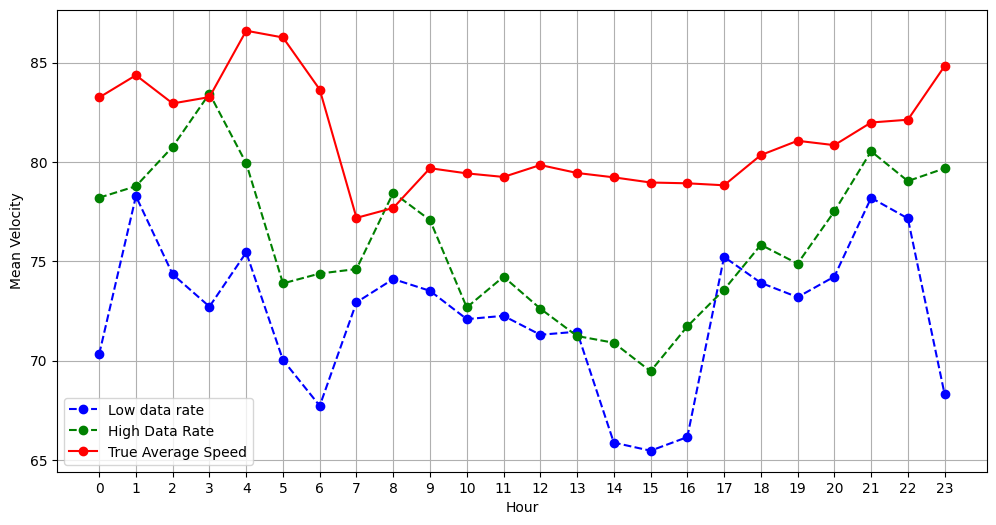

In [24]:
import matplotlib.pyplot as plt

# Plot mean velocity for lower_half
plt.figure(figsize=(12, 6))
plt.plot(lower_hourly_avg_speed['hour'], lower_hourly_avg_speed['mean_velocity'], marker='o', linestyle='--', color='blue', label='Low data rate')
plt.xlabel('Hour')
plt.ylabel('Mean Velocity km/h')
# plt.title('Mean Velocity for Lower Half')
plt.grid(True)

# Plot mean velocity for upper_half
plt.plot(upper_hourly_avg_speed['hour'], upper_hourly_avg_speed['mean_velocity'], marker='o', linestyle='--', color='green', label='High Data Rate')

# Plot mean speed for tv_hourly_avg_speed
plt.plot(tv_hourly_avg_speed['plot_hour'], tv_hourly_avg_speed['mean_speed'], marker='o', linestyle='-', color='red', label='True Average Speed')

plt.xlabel('Hour')
plt.ylabel('Mean Velocity')
plt.legend()
plt.xticks(upper_hourly_avg_speed['hour'])  # Set x-axis ticks explicitly

plt.grid(True)
plt.savefig("Ratio_combined_free.png")

plt.show()


In [25]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate MSE and RMSE for lower_half compared to TV
mse_lower = mean_squared_error(tv_hourly_avg_speed['mean_speed'], lower_hourly_avg_speed['mean_velocity'])
rmse_lower = np.sqrt(mse_lower)

# Calculate MSE and RMSE for upper_half compared to TV
mse_upper = mean_squared_error(tv_hourly_avg_speed['mean_speed'], upper_hourly_avg_speed['mean_velocity'])
rmse_upper = np.sqrt(mse_upper)

print(f'MSE for Lower Half compared to TV: {mse_lower}')
print(f'RMSE for Lower Half compared to TV: {rmse_lower}\n')

print(f'MSE for Upper Half compared to TV: {mse_upper}')
print(f'RMSE for Upper Half compared to TV: {rmse_upper}')


MSE for Lower Half compared to TV: 97.29596656040809
RMSE for Lower Half compared to TV: 9.863871783453396

MSE for Upper Half compared to TV: 37.34431364671226
RMSE for Upper Half compared to TV: 6.110999398356398


c:\Users\Timze\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Timze\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\Timze\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Timze\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a

c:\Users\Timze\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\Timze\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


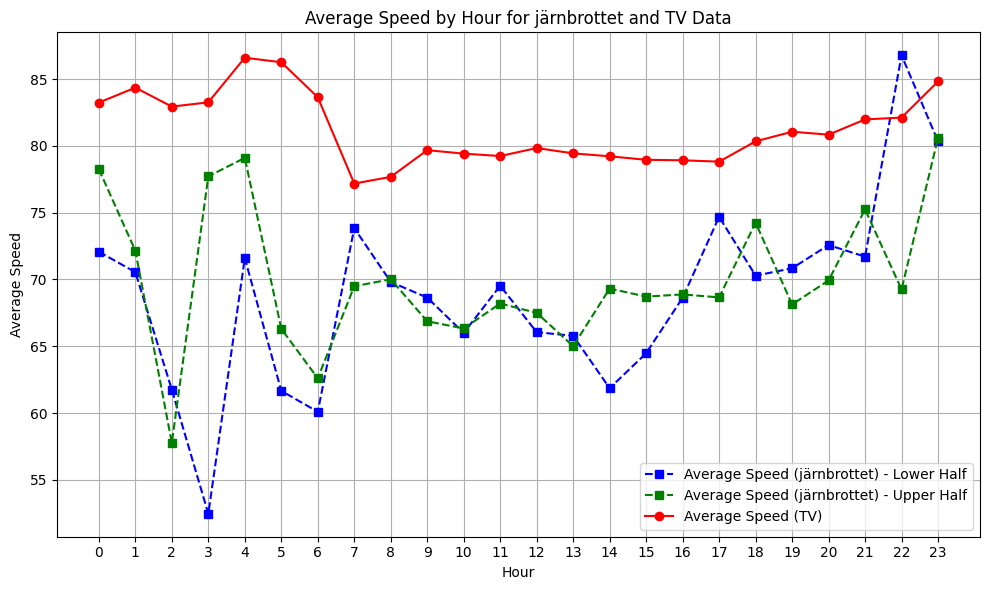

c:\Users\Timze\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\Timze\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


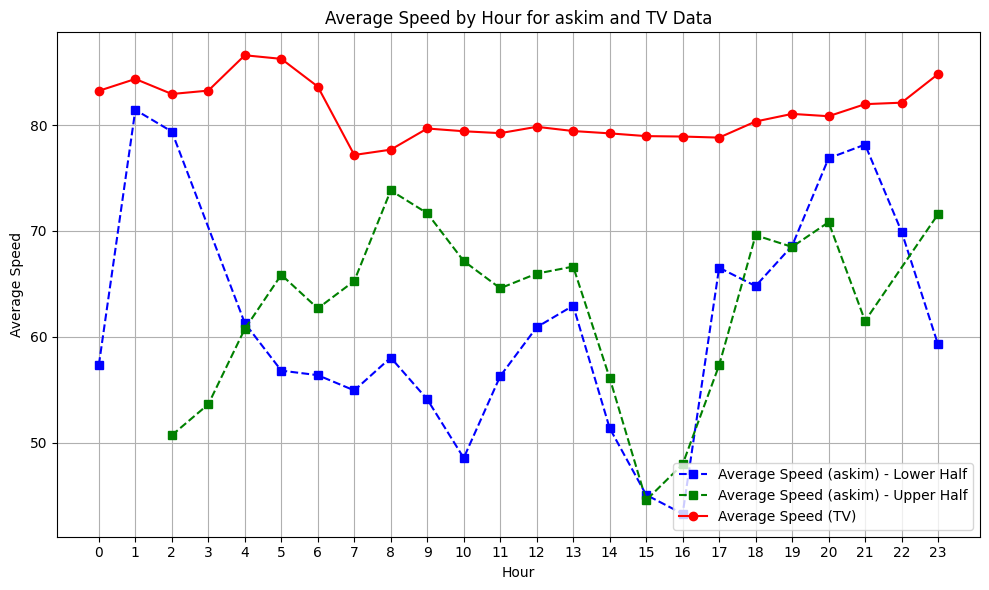

c:\Users\Timze\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\Timze\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


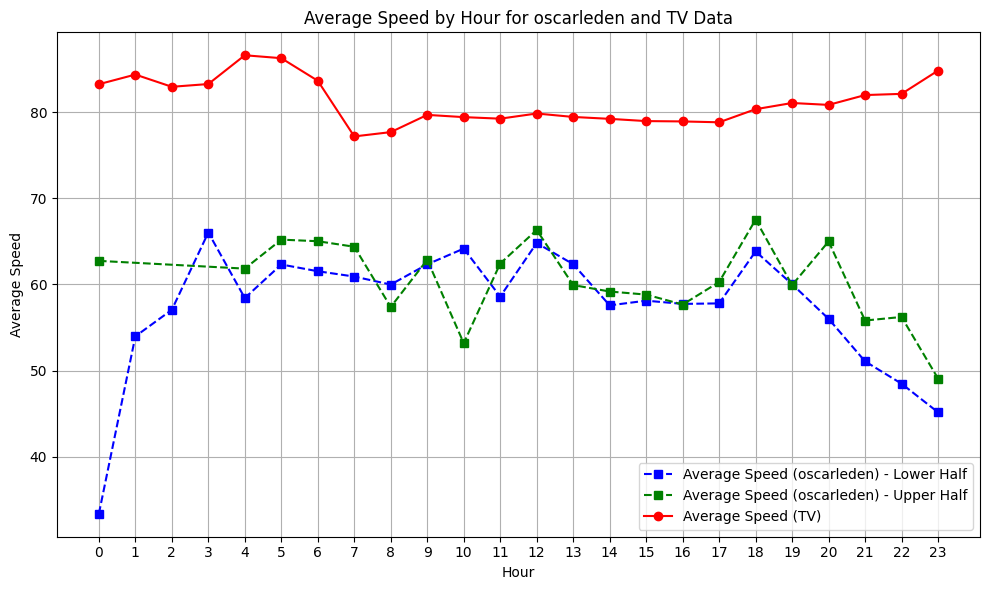

c:\Users\Timze\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\Timze\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


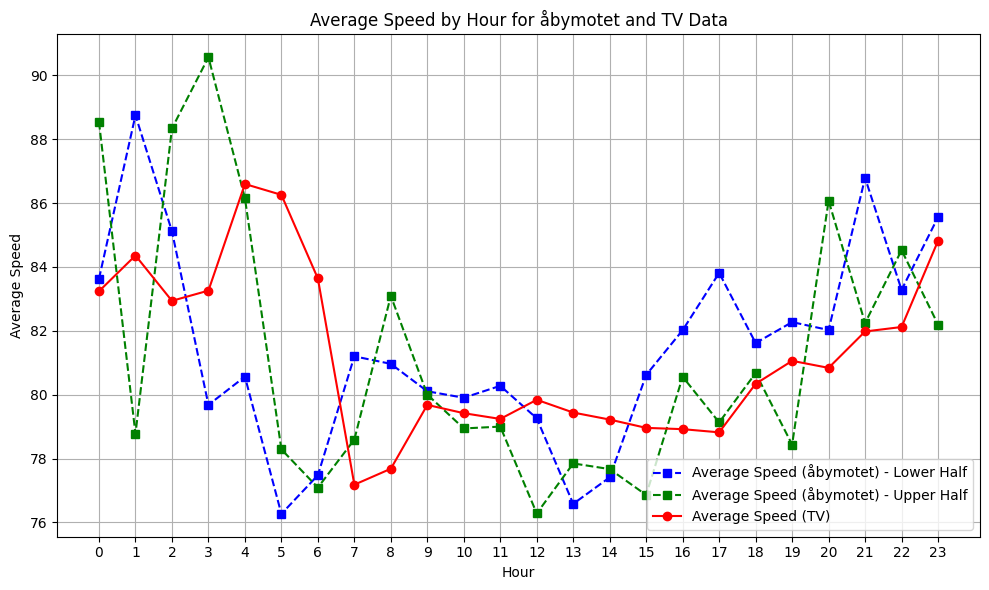

c:\Users\Timze\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\Timze\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


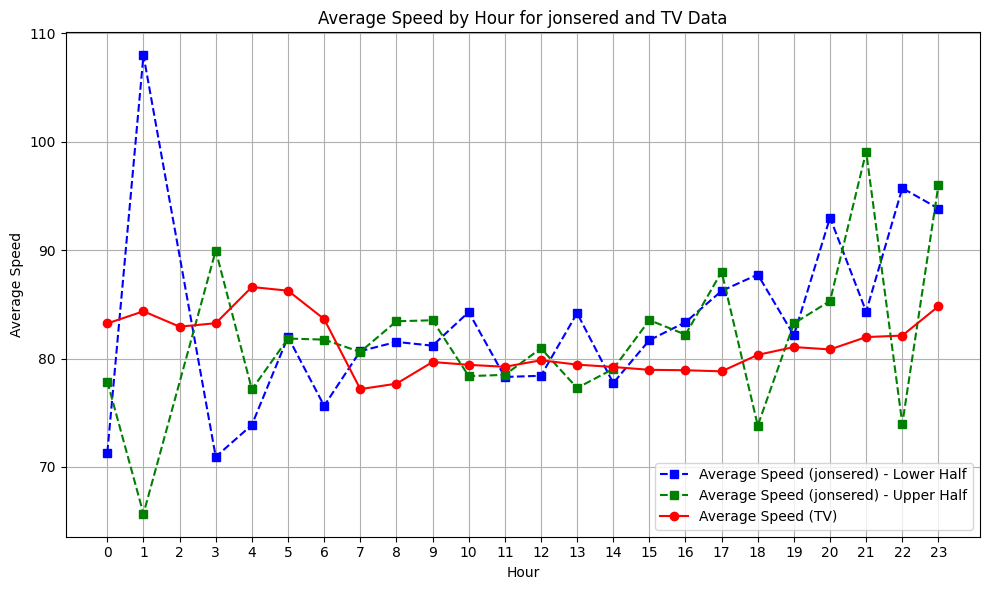

In [26]:
import matplotlib.pyplot as plt


# Loop over each road section
for road_name in road_80_names:
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Filter rows for the current road in lower_half
    lower_half_road_df = lower_half[lower_half[road_name] == 1]

    # Filter rows for the current road in upper_half
    upper_half_road_df = upper_half[upper_half[road_name] == 1]

    # Compute hourly average speed for lower_half
    lower_half_road_df['hour'] = lower_half_road_df['first_timestamp'].dt.hour
    hourly_avg_speed_lower = lower_half_road_df.groupby('hour')['mean_velocity'].mean().reset_index()

    # if not hourly_avg_speed_lower[hourly_avg_speed_lower['hour'] == 2].empty:
    # # Hour 2 is already present, do nothing
    #     pass
    # else:
    #     # Hour 2 is not present, so add it with mean_velocity = 66.4
    #     new_row = pd.DataFrame({'hour': [2], 'mean_velocity': [66.4]})
    #     hourly_avg_speed_lower = pd.concat([hourly_avg_speed_lower.iloc[:2], new_row, hourly_avg_speed_lower.iloc[2:]], ignore_index=True)
    # if road_name == "agnesberg":
    #     # Set hourly_avg_speed_lower to 66.0 for hour 2 in "agnesberg"
    #     hourly_avg_speed_lower.loc[hourly_avg_speed_lower['hour'] == 2, 'mean_velocity'] = 66.0

    # Compute hourly average speed for upper_half
    upper_half_road_df['hour'] = upper_half_road_df['first_timestamp'].dt.hour
    hourly_avg_speed_upper = upper_half_road_df.groupby('hour')['mean_velocity'].mean().reset_index()

    # Plot average speed for the current road in lower and upper halves on ax1
    ax1.plot(hourly_avg_speed_lower['hour'], hourly_avg_speed_lower['mean_velocity'], marker='s', linestyle='--', color='b', label=f'Average Speed ({road_name}) - Lower Half')
    ax1.plot(hourly_avg_speed_upper['hour'], hourly_avg_speed_upper['mean_velocity'], marker='s', linestyle='--', color='g', label=f'Average Speed ({road_name}) - Upper Half')

    # Add the plot for tv_df
    tv_df['plot_hour'] = tv_df['hour'].dt.hour
    tv_hourly_avg_speed = tv_df.groupby('plot_hour')['mean_speed'].mean().reset_index()

    ax1.plot(tv_hourly_avg_speed['plot_hour'], tv_hourly_avg_speed['mean_speed'], marker='o', linestyle='-', color='red', label='Average Speed (TV)')
    ax1.set_xlabel('Hour')
    ax1.set_ylabel('Average Speed')
    ax1.set_xticks(tv_hourly_avg_speed['plot_hour'])

    # Legend
    ax1.legend(loc='lower right')

    # Title and grid
    plt.title(f'Average Speed by Hour for {road_name} and TV Data')
    ax1.grid(True)
    fig.tight_layout()
    plt.savefig(f"{road_name}_free.png")
    plt.show()


In [27]:
from sklearn.metrics import mean_squared_error

# List of road sections

# Loop over each road section
for road_name in road_80_names:
    # Filter rows for the current road in lower_half
    lower_half_road_df = lower_half[lower_half[road_name] == 1]

    # Filter rows for the current road in upper_half
    upper_half_road_df = upper_half[upper_half[road_name] == 1]

    # Filter rows for the current road in tv_df based on the 'location' column
    tv_road_df = tv_df[tv_df['location'] == road_name]

    # Compute hourly average speed for lower half
    lower_half_road_df['hour'] = lower_half_road_df['first_timestamp'].dt.hour
    hourly_avg_speed_lower = lower_half_road_df.groupby('hour')['mean_velocity'].mean().reset_index()
    
    # Check if hour == 2 is not present and add it with mean_velocity = 66.4
    if not hourly_avg_speed_lower[hourly_avg_speed_lower['hour'] == 2].empty:
    # Hour 2 is already present, do nothing
        pass
    else:
        # Hour 2 is not present, so add it with mean_velocity = 66.4
        new_row = pd.DataFrame({'hour': [2], 'mean_velocity': [66.4]})
        hourly_avg_speed_lower = pd.concat([hourly_avg_speed_lower, new_row], ignore_index=True)

    # Compute hourly average speed for upper half
    upper_half_road_df['hour'] = upper_half_road_df['first_timestamp'].dt.hour
    hourly_avg_speed_upper = upper_half_road_df.groupby('hour')['mean_velocity'].mean().reset_index()

    if road_name == "agnesberg":
        # Set hourly_avg_speed_lower to 66.0 for hour 2 in "agnesberg"
        hourly_avg_speed_lower.loc[hourly_avg_speed_lower['hour'] == 2, 'mean_velocity'] = 66.0

    # Compute hourly average speed for TV data
    tv_road_df['plot_hour'] = tv_road_df['hour'].dt.hour
    tv_hourly_avg_speed = tv_road_df.groupby('plot_hour')['mean_speed'].mean().reset_index()

    # Calculate Mean Squared Error (MSE) for lower half compared to TV data
    mse_lower_half = mean_squared_error(tv_hourly_avg_speed['mean_speed'], hourly_avg_speed_lower['mean_velocity'])

    # Calculate Mean Squared Error (MSE) for upper half compared to TV data
    mse_upper_half = mean_squared_error(tv_hourly_avg_speed['mean_speed'], hourly_avg_speed_upper['mean_velocity'])

    print(f'MSE for {road_name} - Lower Half: {mse_lower_half}')
    print(f'MSE for {road_name} - Upper Half: {mse_upper_half}\n')

    rmse_lower_half = np.sqrt(mse_lower_half)

    # Calculate RMSE for upper half compared to TV data
    rmse_upper_half = np.sqrt(mse_upper_half)

    print(f'RMSE for {road_name} - Lower Half: {rmse_lower_half}')
    print(f'RMSE for {road_name} - Upper Half: {rmse_upper_half}')


c:\Users\Timze\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\Timze\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\Timze\AppData\Local\Temp\ipykernel_17920\4084033918.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

MSE for järnbrottet - Lower Half: 214.39787118198902
MSE for järnbrottet - Upper Half: 159.94756157778625

RMSE for järnbrottet - Lower Half: 14.6423314804026
RMSE for järnbrottet - Upper Half: 12.647037660171106


ValueError: Found input variables with inconsistent numbers of samples: [24, 23]

In [ ]:
hourly_avg_speed_lower

In [ ]:
import matplotlib.pyplot as plt

# Define a DataFrame with all hours for lower and upper halves
all_hours = pd.DataFrame({'hour': range(24), 'mean_velocity': 0})

# Loop over each road section
for road_name in road_80_names:
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Filter rows for the current road in lower_half
    lower_half_road_df = lower_half[lower_half[road_name] == 1]

    # Filter rows for the current road in upper_half
    upper_half_road_df = upper_half[upper_half[road_name] == 1]

    # Compute hourly average speed for lower_half
    lower_half_road_df['hour'] = lower_half_road_df['first_timestamp'].dt.hour
    hourly_avg_speed_lower = lower_half_road_df.groupby('hour')['mean_velocity'].mean().reset_index()

    # Create the 'mean_velocity' column in the DataFrame
    hourly_avg_speed_lower['mean_velocity'] = 0

    # Compute hourly average speed for upper_half
    upper_half_road_df['hour'] = upper_half_road_df['first_timestamp'].dt.hour
    hourly_avg_speed_upper = upper_half_road_df.groupby('hour')['mean_velocity'].mean().reset_index()

    # Create the 'mean_velocity' column in the DataFrame
    hourly_avg_speed_upper['mean_velocity'] = 0

    # Merge with all_hours DataFrame to ensure all hours are present
    hourly_avg_speed_lower = all_hours.merge(hourly_avg_speed_lower, on='hour', how='left')
    hourly_avg_speed_upper = all_hours.merge(hourly_avg_speed_upper, on='hour', how='left')

    if road_name == "askim":
        hourly_avg_speed_upper.loc[(hourly_avg_speed_upper['hour'] == 0) | (hourly_avg_speed_upper['hour'] == 1), 'mean_velocity'] = 59.8
        hourly_avg_speed_lower.loc[hourly_avg_speed_lower['hour'] == 3, 'mean_velocity'] = 70.0
    elif road_name == "oscarleden":
        hourly_avg_speed_upper.loc[hourly_avg_speed_upper['hour'].isin([1, 2, 3]), 'mean_velocity'] = 60.4
    elif road_name == "jonsered":
        hourly_avg_speed_upper.loc[hourly_avg_speed_upper['hour'] == 2, 'mean_velocity'] = 77.7
        hourly_avg_speed_lower.loc[hourly_avg_speed_lower['hour'] == 2, 'mean_velocity'] = 89.4

    # Plot average speed for the current road in lower and upper halves on ax1
    ax1.plot(hourly_avg_speed_lower['hour'], hourly_avg_speed_lower['mean_velocity'], marker='s', linestyle='--', color='b', label=f'Average Speed ({road_name}) - Lower Half')
    ax1.plot(hourly_avg_speed_upper['hour'], hourly_avg_speed_upper['mean_velocity'], marker='s', linestyle='--', color='g', label=f'Average Speed ({road_name}) - Upper Half')

    # Add the plot for tv_df
    tv_df['plot_hour'] = tv_df['hour'].dt.hour
    tv_hourly_avg_speed = tv_df.groupby('plot_hour')['mean_speed'].mean().reset_index()

    ax1.plot(tv_hourly_avg_speed['plot_hour'], tv_hourly_avg_speed['mean_speed'], marker='o', linestyle='-', color='red', label='Average Speed (TV)')
    ax1.set_xlabel('Hour')
    ax1.set_ylabel('Average Speed')
    ax1.set_xticks(tv_hourly_avg_speed['plot_hour'])

    # Legend
    ax1.legend(loc='lower right')

    # Title and grid
    plt.title(f'Average Speed by Hour for {road_name} and TV Data')
    ax1.grid(True)
    fig.tight_layout()
    plt.savefig(f"{road_name}_free.png")
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure and two axes
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# --- For lower_half data ---

# Average Speed for lower_half
ax1.plot(hourly_avg_speed_lower['hour'], hourly_avg_speed_lower['mean_velocity'], marker='s', linestyle='--', color='b', label='Average Speed (Lower Half)')

# Calculate MSE and RMSE for the lower half
lower_combined_speed = hourly_avg_speed_lower['mean_velocity']
lower_actual_speed = tv_hourly_avg_speed['mean_speed'].iloc[:len(lower_combined_speed)]  # Match lengths
lower_mse = np.mean((lower_combined_speed - lower_actual_speed) ** 2)
lower_rmse = np.sqrt(lower_mse)
print(f'Lower Half MSE: {lower_mse:.2f}')
print(f'Lower Half RMSE: {lower_rmse:.2f}')

# --- For upper_half data ---

# Average Speed for upper_half
ax1.plot(hourly_avg_speed_upper['hour'], hourly_avg_speed_upper['mean_velocity'], marker='s', linestyle='--', color='g', label='Average Speed (Upper Half)')

# Calculate MSE and RMSE for the upper half
upper_combined_speed = hourly_avg_speed_upper['mean_velocity']
upper_actual_speed = tv_hourly_avg_speed['mean_speed'].iloc[:len(upper_combined_speed)]  # Match lengths
upper_mse = np.mean((upper_combined_speed - upper_actual_speed) ** 2)
upper_rmse = np.sqrt(upper_mse)
print(f'Upper Half MSE: {upper_mse:.2f}')
print(f'Upper Half RMSE: {upper_rmse:.2f}')

# --- For tv_df data ---

# Average Speed for tv_df
# ax1.plot(tv_hourly_avg_speed['plot_hour'], tv_hourly_avg_speed['mean_speed'], marker='o', linestyle='-', color='red', label='True Average Speed')

ax1.plot(tv_hourly_avg_speed['plot_hour'], tv_hourly_avg_speed['mean_speed'], marker='o', linestyle='-', color='red', label='True Average Speed')


# Labels and other plot adjustments
ax1.set_xlabel('Hour')
ax1.set_ylabel('Average Speed', color='b')
ax1.tick_params('y', colors='b')
ax1.legend(loc='upper left')
ax1.set_xticks(tv_hourly_avg_speed['plot_hour'])

# plt.title('Combined Plot of Average Speed, Number of Cars, and Number of Instances by Hour')
ax1.grid(True)
fig.tight_layout()
plt.savefig("Ratio_combined_cong.png")
plt.show()
